In [38]:
%matplotlib inline
%load_ext rpy2.ipython


import datetime as dt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import statsmodels.api as sm
from pykalman import KalmanFilter
import numpy.ma as ma

pd.set_option('max_rows', 10)
# pd.set_option('max_rows', 1000)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [39]:
%%R

library(MARSS)

# Data

## Regressors

In [40]:
monthlyData = pd.read_excel('monthlyData.xlsx',None,dayFirst=True)

monthlyData = list(monthlyData.values())

dat=pd.DataFrame()

# del monthlyData[6]


for df in monthlyData:
    df.set_index("Date", inplace=True)
#     df.drop_duplicates(inplace=True)

In [41]:
monthlyData = pd.concat(monthlyData,axis=1)
monthlyData.sort_index(inplace=True)

### Transformations


In [5]:
monthlyData.columns

Index(['RetailFoodSales', 'ProducerPriceIndex', 'JoblessClaims',
       'ConsumerPriceIndex', 'DisposableIncome', 'GeneralBusinessConditions',
       'ConsumerConfidence', 'NewResidentialSales', 'Imports', 'Exports',
       'UnemploymentRate', 'IndustrialProductionIndex', 'EmploymentRate'],
      dtype='object')

In [36]:
monthlyData["IndustrialProductionIndex"] = np.log(monthlyData["IndustrialProductionIndex"]) - np.log(monthlyData["IndustrialProductionIndex"].shift(1))
monthlyData["ConsumerConfidence"] = np.log(monthlyData["ConsumerConfidence"]) - np.log(monthlyData["ConsumerConfidence"].shift(1))
monthlyData["Imports"] = np.log(monthlyData["Imports"]) - np.log(monthlyData["Imports"].shift(1))
monthlyData["Exports"] = np.log(monthlyData["Exports"]) - np.log(monthlyData["Exports"].shift(1))
monthlyData["ProducerPriceIndex"] = np.log(monthlyData["ProducerPriceIndex"]) - np.log(monthlyData["ProducerPriceIndex"].shift(1))
monthlyData["JoblessClaims"] = np.log(monthlyData["JoblessClaims"]) - np.log(monthlyData["JoblessClaims"].shift(1))
monthlyData["RetailFoodSales"] = np.log(monthlyData["RetailFoodSales"]) - np.log(monthlyData["RetailFoodSales"].shift(1))
monthlyData["NewResidentialSales"] = np.log(monthlyData["NewResidentialSales"]) - np.log(monthlyData["NewResidentialSales"].shift(1))
monthlyData["UnemploymentRate"] = monthlyData["UnemploymentRate"] - monthlyData["UnemploymentRate"].shift(1)
monthlyData["EmploymentRate"] = monthlyData["EmploymentRate"] - monthlyData["EmploymentRate"].shift(1)
monthlyData["DisposableIncome"] = np.log(monthlyData["DisposableIncome"]) - np.log(monthlyData["DisposableIncome"].shift(1))
monthlyData["GeneralBusinessConditions"] = np.log(monthlyData["GeneralBusinessConditions"]) - np.log(monthlyData["GeneralBusinessConditions"].shift(1))
monthlyData["ConsumerPriceIndex"] = monthlyData["ConsumerPriceIndex"]

# monthlyData["ConsumerPriceIndex"].loc[dt.datetime(2009,1,1):].plot()

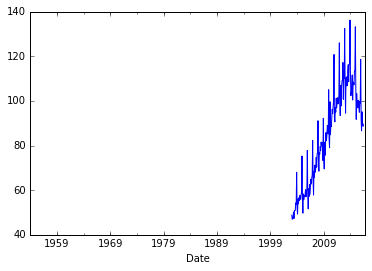

In [35]:
monthlyData["RetailFoodSales"].plot()

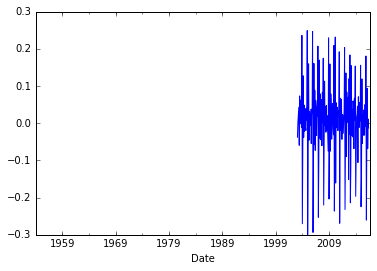

In [37]:
monthlyData["RetailFoodSales"].plot()

In [48]:
x

Date
2000-01-31     NaN
2000-02-29     NaN
2000-03-31     NaN
2000-04-30     NaN
2000-05-31     NaN
              ... 
2016-06-30    88.7
2016-07-31     NaN
2016-08-31     NaN
2016-09-30     NaN
2016-10-31     NaN
Freq: M, Name: RetailFoodSales, dtype: float64

### Stationarity

In [7]:
for series in monthlyData.columns:
    d = monthlyData[series]    
    pv = sm.tsa.stattools.adfuller(d[d.notnull()])[1]
    if pv > 0.05:
        print(series + " 's p-value is: " + str(pv))

RetailFoodSales 's p-value is: 0.627133470279
JoblessClaims 's p-value is: 0.24770534847
NewResidentialSales 's p-value is: 0.988370553646
EmploymentRate 's p-value is: 0.345649514846


## Response Variable

In [8]:
gdp = pd.read_excel('GDP.xlsx',dayFirst=True)
gdp.set_index("Date", inplace=True)
gdp["GDP"] = np.log(gdp["GDP"]) - np.log(gdp["GDP"].shift(1))

# Balanced Panel

In [9]:
balancedIndex = ~monthlyData.isnull().any(axis=1)
monthlyData[balancedIndex]

,RetailFoodSales,ProducerPriceIndex,JoblessClaims,ConsumerPriceIndex,DisposableIncome,GeneralBusinessConditions,ConsumerConfidence,NewResidentialSales,Imports,Exports,UnemploymentRate,IndustrialProductionIndex,EmploymentRate
Date,,,,,,,,,,,,,
2010-01-31,-0.236325,0.014889,-0.188285,0.75,0.008873,0.020834,0.016840,0.013766,-0.067987,-0.246317,-0.001,-0.069069,-0.004
2010-02-28,-0.048187,0.012143,0.069042,0.78,0.004470,0.051153,-0.067030,0.035409,0.027679,0.075958,0.004,-0.001136,-0.002
2010-03-31,0.231714,-0.001559,0.165317,0.52,-0.018580,0.029827,0.035091,0.046870,0.242947,0.254201,0.009,0.180426,-0.002
2010-04-30,-0.160867,0.003989,-0.136788,0.57,0.007699,0.002590,0.003038,0.030556,-0.081357,-0.036670,0.002,-0.083052,0.003
2010-05-31,0.055060,0.004650,0.029296,0.43,0.004203,-0.007789,0.023977,0.036153,0.026540,0.154966,0.000,0.039419,-0.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-09-30,-0.032144,0.029448,-0.038988,0.54,0.004298,-0.027365,-0.064633,0.010601,0.031345,0.041913,0.003,0.001036,0.000
2015-10-31,0.050344,0.017563,-0.011137,0.82,0.022878,0.032261,0.040154,0.006654,0.062352,-0.006162,0.001,0.036589,-0.003
2015-11-30,-0.008048,-0.004184,-0.071361,1.01,0.048696,-0.090681,0.000000,0.004195,-0.108404,-0.150516,-0.002,-0.071348,0.003


In [10]:
n_components=1
pca = PCA(n_components=n_components)
components = pca.fit_transform(monthlyData[balancedIndex])
components = pd.DataFrame(components)
components.set_index(monthlyData[balancedIndex].index, inplace=True)

print(pca.explained_variance_ratio_) 

[ 0.6241585]


## MARSS R-Package

In [11]:
balancedPanel = monthlyData[balancedIndex].transpose().as_matrix()
initial = components.transpose().as_matrix()

zs = []
for i in range(0,26):
    zs.append('z'+str(i))

In [12]:
%%R -i balancedPanel,zs,initial -o states

# class(meas)

Z="unconstrained"
# B="diagonal and unequal"
# B="identity"
B="unconstrained"
# x0=matrix(c("pi1"),1,1)
# x0=matrix(c("pi1","pi2"),2,1)

Z=matrix(list("z1","z2","z3","z4","z5","z6","z7","z8","z9","z10","z11","z12","z13"),13,1)
# Z=matrix(zs,13,2)

x0="zero"
x0=initial

model.gen=list(Z=Z,B=B,A="zero",x0="zero",U="zero")
# model.gen=list(Z=Z,B=B,x0=x0,A="zero")
kemfit = MARSS(balancedPanel, model=model.gen,control=list(conv.test.slope.tol=0.00001,abstol=0.00001))
states = kemfit$states
# print(kemfit, what="model")
# print(kemfit, what="start")
# print(kemfit, what="states")
# print(kemfit, what="ytT")
# print(kemfit, what="states.se")
# print(kemfit, what="kfs")
# print(kemfit$par$Z)

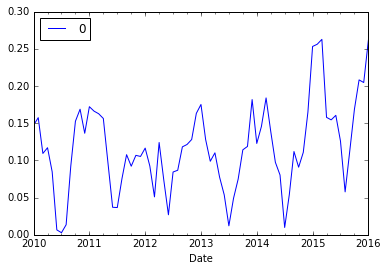

In [13]:
factor = pd.DataFrame(states).transpose().set_index(monthlyData[balancedIndex].index)
factor.plot()

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


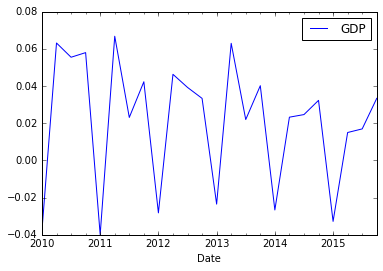

In [14]:
gdp[balancedIndex].plot()

# OLS - Nowcast

In [15]:
factor = factor.rolling(window=3).sum()
olsSample = gdp.join(factor, how="inner")
gdpComp = olsSample[0]

In [16]:
# X = sm.add_constant(gdpComp)
X = gdpComp
model = sm.OLS(olsSample["GDP"],X)
results = model.fit()
results.params
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    GDP   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     2.799
Date:                Fri, 23 Dec 2016   Prob (F-statistic):              0.108
Time:                        10:50:42   Log-Likelihood:                 44.699
No. Observations:                  24   AIC:                            -87.40
Df Residuals:                      23   BIC:                            -86.22
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.0348      0.021      1.673      0.1

The model is not a good fit. We believe that could be due to the lack of specification of initial value for the parameters. Thus we will try do find initial value for the parameters running a VAR on PCA components, as in Banbura et al. 2013

# PCA to retrieve factors from balanced panel

In [17]:
n_components=5
pca = PCA(n_components=n_components)
components = pca.fit_transform(monthlyData[balancedIndex])
components = pd.DataFrame(components)
components.set_index(monthlyData[balancedIndex].index, inplace=True)

print(pca.explained_variance_ratio_) 

[ 0.6241585   0.22421535  0.08139473  0.02986808  0.01642318]


In [18]:
sum(pca.explained_variance_ratio_)

0.97605984190422534

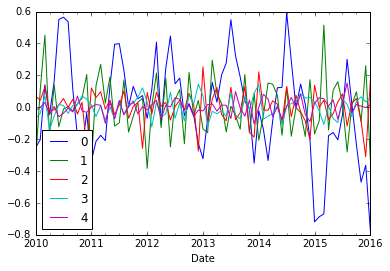

In [19]:
pd.DataFrame(components).plot()

# Initial Parameters Estimation 
## VAR - for B-Matrix Estimation

In [20]:
varModel = sm.tsa.VAR(components)
results = varModel.fit(1)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 23, Dec, 2016
Time:                     10:50:43
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -22.1591
Nobs:                     72.0000    HQIC:                  -22.7301
Log likelihood:           351.061    FPE:                9.23150e-11
AIC:                     -23.1078    Det(Omega_mle):     6.18674e-11
--------------------------------------------------------------------
Results for equation 0
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const        -0.003938         0.023643           -0.167           0.868
L1.0          0.700590         0.082908            8.450           0.000
L1.1         -0.088209         0.134782           -0.654           0.515
L1.2          0.423460 

In [21]:
initialB = pd.DataFrame(results.coefs[0])

## OLS For Z-Matrix estimation

In [22]:
results = sm.OLS(monthlyData[balancedIndex]['ConsumerConfidence'], components).fit()
results.params

0    0.026572
1   -0.000310
2    0.005678
3    0.045861
4    0.077941
dtype: float64

In [23]:
dfList = []
for col in monthlyData[balancedIndex].columns:
    results = sm.OLS(monthlyData[balancedIndex][col], components).fit()
    dfList.append(results.params)

initialZ = pd.concat(dfList,axis=1).transpose()
initialZ

,0,1,2,3,4
0,0.115118,0.479418,-0.431064,0.521580,0.068239
1,-0.000789,-0.003003,0.004543,-0.001386,0.018411
2,0.047185,0.296605,0.024675,0.499237,0.160976
3,-0.979236,0.189912,0.025137,0.025244,0.038386
4,0.004073,-0.017351,-0.083441,0.055275,-0.104737
...,...,...,...,...,...
8,0.068671,0.311816,0.726352,0.202369,-0.549040
9,0.106977,0.709957,-0.185781,-0.637822,-0.111593
10,-0.003501,0.003605,0.009224,-0.019934,0.017436
11,0.091358,0.210319,0.473270,-0.061192,0.773552


# Re-Estimation of Factor Model by EM Algo

In [24]:
initialB.shape

(5, 5)

In [25]:
initialZ = np.reshape(initialZ.stack().as_matrix(),(65,1))
initialB = np.reshape(initialB.stack().as_matrix(),(25,1))
print(initialZ.shape)
print(initialB.shape)

(65, 1)
(25, 1)


In [26]:
numberOfFactors = 5
zs = []
for i in range(0,13*numberOfFactors):
    zs.append('z'+str(i))
    


In [27]:
%%R -i balancedPanel,zs,initialB,initialZ,numberOfFactors -o states

# class(meas)
print(dim(initialZ))
Z="unconstrained"
# B="diagonal and unequal"
# B="identity"
B="unconstrained"
# x0=matrix(c("pi1"),1,1)
# x0=matrix(c("pi1","pi2"),2,1)

# Z=matrix(list("z1","z2","z3","z4","z5","z6","z7","z8","z9","z10","z11","z12","z13"),13,1)
Z=matrix(zs,13,numberOfFactors)
# print(Z)
# print(numberOfFactors)
inits = list(Z=initialZ, B=initialB)

x0="zero"
x0=initial

model.gen=list(Z=Z,B=B,A="zero",x0="zero",U="zero")
# model.gen=list(Z=Z,B=B,x0=x0,A="zero")
# kemfit = MARSS(balancedPanel, model=model.gen)
# kemfit = MARSS(balancedPanel, model=model.gen,control=list(conv.test.slope.tol=0.00001,abstol=0.00001))
# kemfit = MARSS(balancedPanel, model=model.gen,control=list(conv.test.slope.tol=0.00001,abstol=0.00001),inits=inits)
kemfit = MARSS(balancedPanel, model=model.gen,inits=inits)
states = kemfit$states
# print(kemfit, what="model")
# print(kemfit, what="start")
# print(kemfit, what="states")
# print(kemfit, what="ytT")
# print(kemfit, what="states.se")
# print(kemfit, what="kfs")
print(dim(kemfit$par$Z))

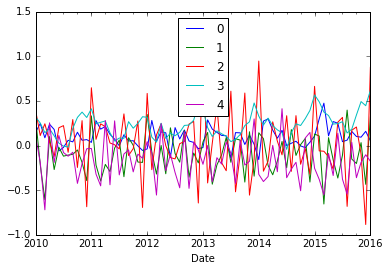

In [28]:
factor = pd.DataFrame(states).transpose().set_index(monthlyData[balancedIndex].index)
factor.plot()

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


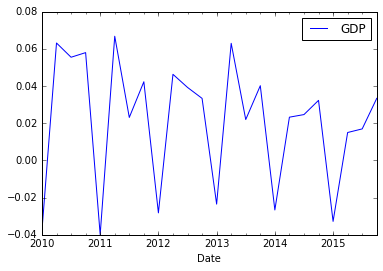

In [29]:
gdp[balancedIndex].plot()

# OLS - Nowcast

In [30]:
# factor = factor.rolling(window=3).sum()
olsSample = gdp.join(factor, how="inner")
gdpComp = olsSample[[0,1,2,3,4]]

In [31]:
gdpComp.head()

,0,1,2,3,4
Date,,,,,
2010-03-31,0.086510,-0.607694,0.243709,0.144331,-0.720051
2010-06-30,-0.060588,-0.019493,0.198876,0.026757,0.112326
2010-09-30,0.040825,-0.098910,0.290914,0.191299,-0.075508
2010-12-31,0.066327,-0.392930,-0.685454,0.313953,-0.035924
2011-03-31,0.183677,-0.397789,0.242626,0.260277,-0.451794


In [32]:
# X = sm.add_constant(gdpComp)
X = gdpComp
model = sm.OLS(olsSample["GDP"],X)
results = model.fit()
results.params
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    GDP   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.530
Method:                 Least Squares   F-statistic:                     6.407
Date:                Fri, 23 Dec 2016   Prob (F-statistic):            0.00120
Time:                        10:51:27   Log-Likelihood:                 55.178
No. Observations:                  24   AIC:                            -100.4
Df Residuals:                      19   BIC:                            -94.47
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
0             -0.0549      0.049     -1.111      0.2

Next Steps:

* Compare PCA Factors to Smoothed Factors
* Compare Predicted GDP to actual